In [1]:
import torch
import scanpy as sc
import scdiffusion as sd


/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
DATA_PATH = 'data/'
OUTPUT_PATH = 'outputs/'

# Load dataset

In [4]:
adata = sc.read_h5ad(DATA_PATH + 'adata.h5ad')
adata

AnnData object with n_obs × n_vars = 18837 × 4210
    obs: 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types'
    uns: 'benchmark_traj'

# Preprocess

/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:222: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


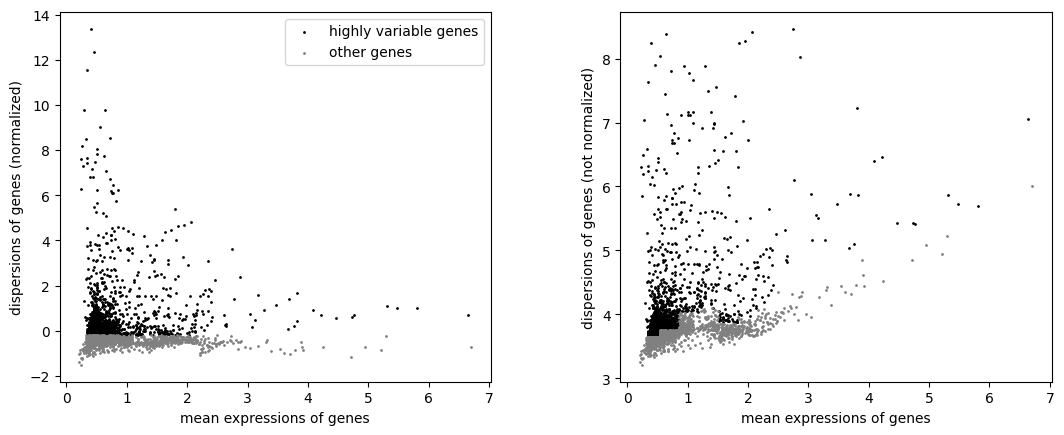

In [5]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [6]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
adata


View of AnnData object with n_obs × n_vars = 18837 × 2000
    obs: 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'benchmark_traj', 'log1p', 'hvg'

We use the normalized and log transformed data (NOT scaled data).

# Feature encoder

In [7]:
sd.encode_features(adata, 
                   D_encode_list=[2000, 300, 50], 
                   D_decode_list=[50, 300, 2000], 
                   max_epoch=2000, lr=1e-3, 
                   device=device)


2024-10-17 12:07:59,979 - --------> Starting feature encoder ...
/projectnb/czproj/Algorithms/ycliu/scDiffusion/diffusion/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)
2024-10-17 12:08:01,058 - ------------------------> Epoch: 1/2000, Current loss: 19219126.0000
2024-10-17 12:08:02,608 - ------------------------> Epoch: 51/2000, Current loss: 11480110.0000
2024-10-17 12:08:04,156 - ------------------------> Epoch: 101/2000, Current loss: 10701251.0000
2024-10-17 12:08:05,705 - ------------------------> Epoch: 151/2000, Current loss: 10281102.0000
2024-10-17 12:08:07,254 - ------------------------> Epoch: 201/2000, Current loss: 10090144.0000
2024-10-17 12:08:08,805 - ------------------------> Epoch: 251/2000, Current loss: 999

## Check isolated nodes (Not necessary)

In [8]:
sd.util.evaluate_node_isolation(adata, use_rep='X_fae', predict_pct=0.15)

The isolation inofrmation can be used to prune edges for single cell graph.

# Diffusion

In [9]:
# This graph provides the adjacency that will be used in loss function.
sd.graph.build_adj_graph(adata, use_rep=None, k=50, data_dtype = torch.float32, device=device)

In [10]:
# This graph is used in the graph neural diffusion process.
sd.graph.build_diffusion_graph(adata, use_rep='X_fae', k=50, prune=False, device=device)

If prune=True, edges will be pruned according to the isolation labels for graph-nodes.

In [11]:
sd.graph_diffusion(adata, 
                   use_rep='X_fae', 
                   max_epoch=2000, 
                   lr=1e-3, 
                   time_increment_diffusion=0.2,  
                   loss_adj=0.0,
                   edge_rewire=False, # Set as False to keep more inter-cluster relationships for trajectory inference and accelerate the training process.
                   device=device)


2024-10-17 12:09:03,545 - --------> Starting graph nueral diffusion ...
/projectnb/czproj/Algorithms/ycliu/scDiffusion/diffusion/graph_DIF.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(adjacency, dtype = recon_adj.dtype)
/projectnb/czproj/Algorithms/ycliu/scDiffusion/diffusion/graph_DIF.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_2 = torch.tensor(target_features, dtype = out_nodes_features.dtype)
2024-10-17 12:09:04,327 - ------------------------> Epoch: 1/2000, Current loss: 29439976.0000
2024-10-17 12:09:16,307 - ------------------------> Epoch: 51/2000, Current loss: 11659251.0000
2024-10-17 12:09:28,303 - ------------------------> Epoc

Edge rewiring during the diffusion process typically increases the separation between cell groups while making each group more condensed. Set edge_rewire to True if you want to organize your data into more distinct clusters. Setting edge_rewire to False may preserve more inter-cluster relationships and appreciably accelerate the training process. In trajectory inference, we want to keep more inter-cluster relationships to find the lineage information. We set edge_rewire to False here.

## View UMAP of diffused embeddings

In [12]:
sc.pp.neighbors(adata, use_rep='X_dif', n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


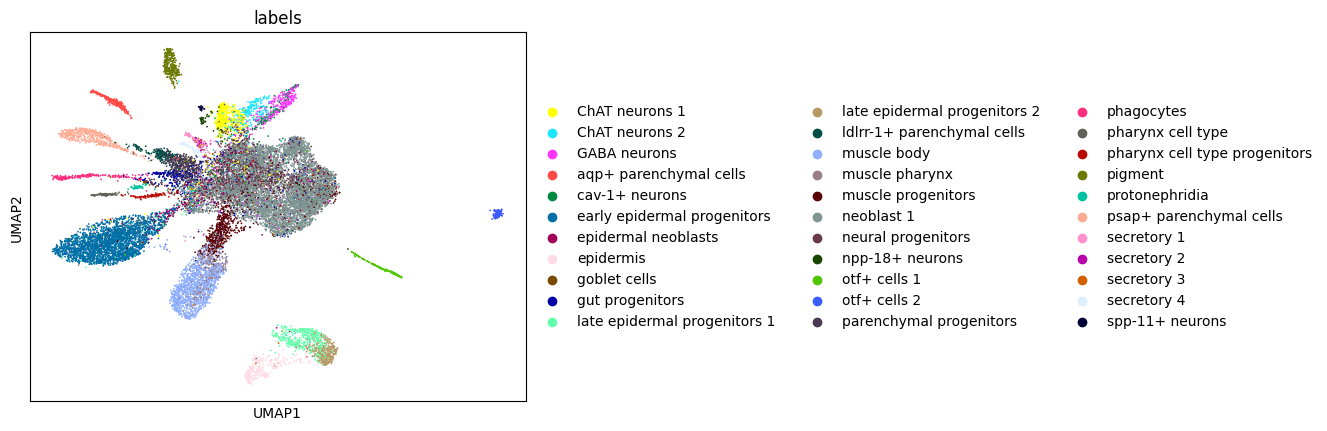

In [13]:
sc.pl.umap(adata, color=['labels'])

# Trajectory

In [14]:
sd.graph.build_graph(adata, use_rep="X_dif", k=50, device=device)

In [15]:
sd.graph.call_attention(adata, device=device)

In [16]:
sd.anal.build_trajectory(adata, 
                     use_groups = 'labels',
                     origin_group = 'neoblast 1',
                     use_community=None,
                     use_rep = 'X_dif',
                     use_weights = 'attention', 
                     traj_shape='mdo_tree',
                     device=device,
                     save_csv = None)

/projectnb/czproj/Algorithms/ycliu/scDiffusion/sc_analysis/trajectory.py:131: RuntimeWarning: divide by zero encountered in divide
  attention_matrix = 1/(numpy.log(aaa + 1))


## Show trajectory in an edge list [(from, to, attention weight),]

In [17]:
adata.uns['trajectory']

[('neoblast 1', 'epidermal neoblasts', 0.83325666),
 ('neoblast 1', 'neural progenitors', 1.0353715),
 ('neoblast 1', 'gut progenitors', 1.041811),
 ('neoblast 1', 'pharynx cell type progenitors', 1.066124),
 ('neoblast 1', 'parenchymal progenitors', 1.3040725),
 ('gut progenitors', 'goblet cells', 0.41560534),
 ('pharynx cell type progenitors', 'pharynx cell type', 0.54517734),
 ('neoblast 1', 'secretory 4', 1.6733763),
 ('neoblast 1', 'muscle progenitors', 1.6782756),
 ('gut progenitors', 'phagocytes', 0.6643656),
 ('parenchymal progenitors', 'ldlrr-1+ parenchymal cells', 0.4150548),
 ('neural progenitors', 'npp-18+ neurons', 0.7589697),
 ('neural progenitors', 'cav-1+ neurons', 0.76928294),
 ('neoblast 1', 'secretory 1', 1.8162818),
 ('goblet cells', 'protonephridia', 0.41076595),
 ('neural progenitors', 'ChAT neurons 1', 0.8445688),
 ('epidermal neoblasts', 'early epidermal progenitors', 1.1416289),
 ('neural progenitors', 'secretory 3', 0.9463241),
 ('neural progenitors', 'ChAT ne

## Trajectory visualization

In [18]:
# Use points to represent cell types in UMAP plot.
sd.anal.community_umap(adata, use_umap = 'X_umap')

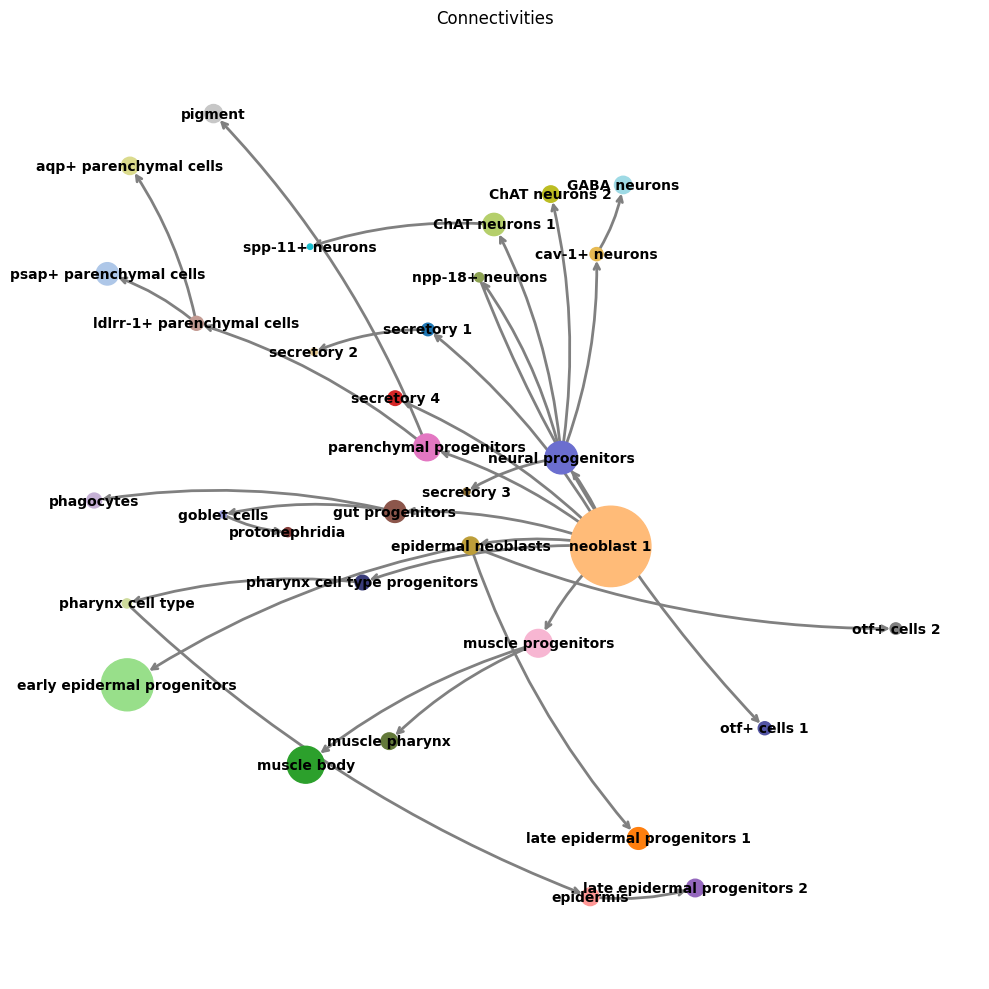

In [19]:
sd.anal.plot_trajectory(adata, 
                        node_scale = 10000, 
                        node_color = None,
                        edge_width=2, 
                        edge_color='gray', 
                        figsize=(10, 10), 
                        font_size=10, 
                        font_weight='bold',
                        title='Connectivities',
                        save_fig=None)

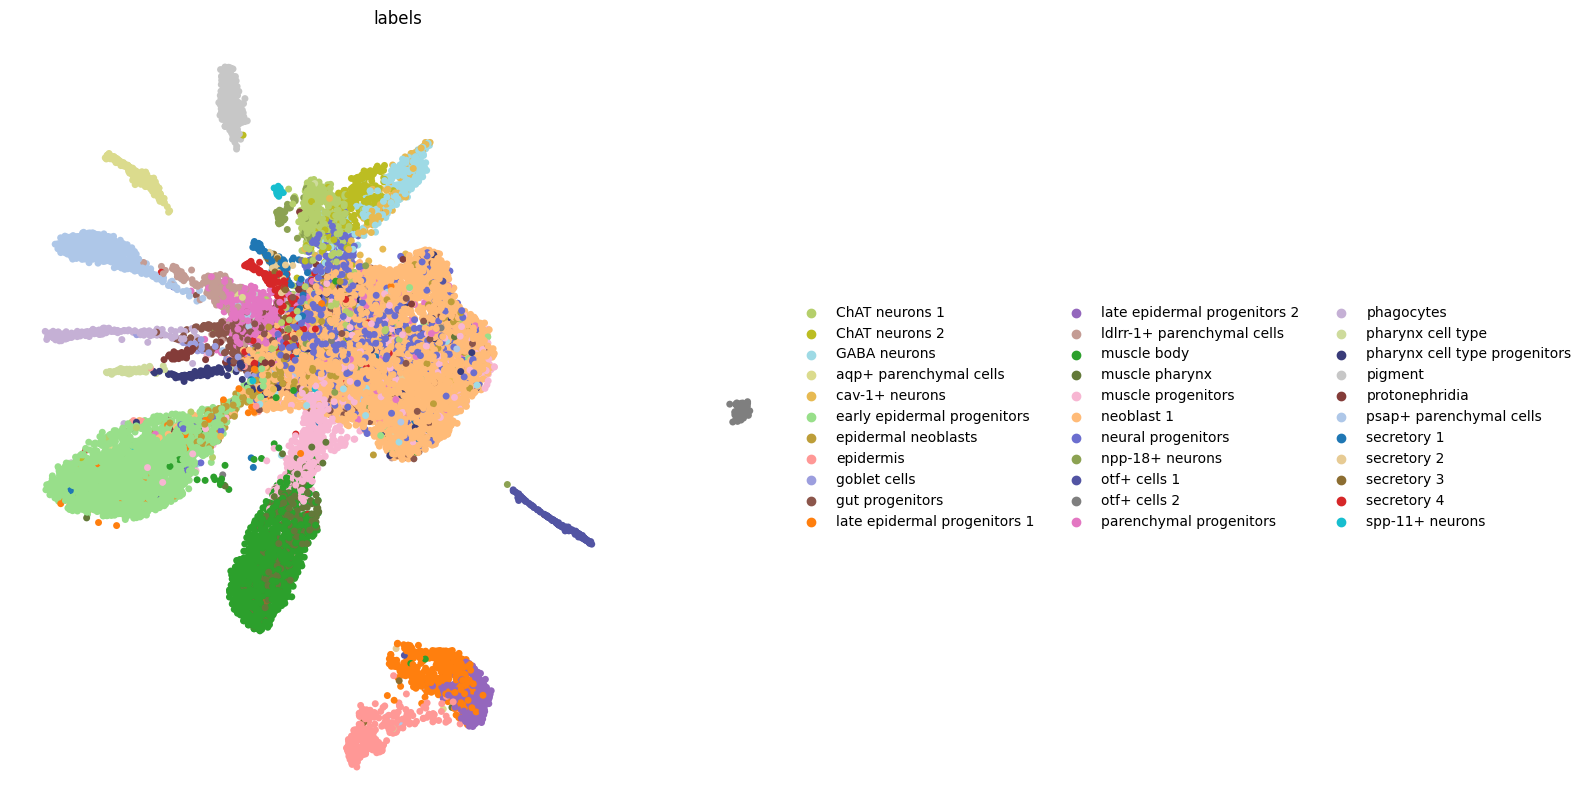

In [20]:
# Plot UMAP with the same color_map for cell types as the trajectory plot

import numpy as np
from matplotlib import rcParams

FIGSIZE = (10, 10)
rcParams["figure.figsize"] = FIGSIZE

unique_values = np.array(adata.uns['community']['keys'])
colors = sd.util.unique_colors(unique_values)
palette = {cell_type: color for cell_type, color in zip(unique_values, colors)}

sc.pl.umap(adata, color=['labels'], palette = palette, frameon=False, 
           legend_fontsize = 10,
           size=100)


# Save data

In [21]:
adata.write(OUTPUT_PATH+'scDiffusion_adata.h5ad')

In [22]:
adata = sc.read_h5ad(OUTPUT_PATH+'scDiffusion_adata.h5ad')